# The Impact of Climate Change on Groundwater Recharge in the Sonoran Desert
Simulating groundwater recharge with application of the PCR-GLOBWB model. First step is to load all the needed packages.

In [1]:
# This cell is only used to suppress some distracting output messages
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import matplotlib.pyplot as plt
from cartopy import crs
from cartopy import feature as cfeature
import fiona
import shapely.geometry
from pyproj import Geod
from rich import print
import pandas as pd
import xarray as xr

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.parameter_sets

Next, the forcings and parameterset are computed.

In [3]:
station_latitude = 32.76108802182168 #Gila near Yuma
station_longitude = -114.41721725761596

In [4]:
parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory="/data/shared/parameter-sets/pcrglobwb_global",
    config="./pcrglobwb_sonoran_05min.ini",
    target_model="pcrglobwb",
    supported_model_versions={"setters"},
)
#print(parameter_set)

In [5]:
forcing = ewatercycle.forcing.sources["PCRGlobWBForcing"].load(
    directory="/home/emol/forcing/sonoran_desert/work/diagnostic/script",
)
#print(forcing)

In [6]:
pcrglob = ewatercycle.models.PCRGlobWB(
    parameter_set=parameter_set,
    forcing=forcing
)
print(pcrglob)

PCRGlobWB(
    parameter_set=ParameterSet(
        name='custom_parameter_set',
        directory=PosixPath('/data/shared/parameter-sets/pcrglobwb_global'),
        config=PosixPath('pcrglobwb_sonoran_05min.ini'),
        doi='N/A',
        target_model='pcrglobwb',
        supported_model_versions={'setters'},
        downloader=None
    ),
    forcing=PCRGlobWBForcing(
        start_time='1997-08-01T00:00:00Z',
        end_time='2000-08-31T00:00:00Z',
        directory=PosixPath('/home/emol/forcing/sonoran_desert/work/diagnostic/script'),
        shape=PosixPath('/home/emol/forcing/sonoran_desert/work/diagnostic/script/hysets_09488650.shp'),
        filenames={},
        precipitationNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_pr_1997-2000_hysets_09488650.nc',
        temperatureNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_tas_1997-2000_hysets_09488650.nc'
    )
)

In [7]:
cfg_file, cfg_dir = pcrglob.setup(
    start_time="1997-08-01T00:00:00Z",
    end_time="1997-12-31T00:00:00Z",
    max_spinups_in_years=0
)
cfg_file, cfg_dir

('/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Drafts/sonoran_desert/pcrglobwb_20241212_091431/pcrglobwb_ewatercycle.ini',
 '/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Drafts/sonoran_desert/pcrglobwb_20241212_091431')

In [8]:
pcrglob.initialize(cfg_file)

In [9]:
time = pd.date_range(pcrglob.start_time_as_isostr, pcrglob.end_time_as_isostr)
timeseries = pd.DataFrame(
    index=pd.Index(time, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)
timeseries.head()

,PCRGlobWB: Sonoran Desert
time,
1997-08-01 00:00:00+00:00,NaN
1997-08-02 00:00:00+00:00,NaN
1997-08-03 00:00:00+00:00,NaN
1997-08-04 00:00:00+00:00,NaN
1997-08-05 00:00:00+00:00,NaN


In [10]:
while pcrglob.time < pcrglob.end_time:
    pcrglob.update()

    # Track discharge at station location
    discharge_at_station = pcrglob.get_value_at_coords(
        "groundwater_recharge", lat=[station_latitude], lon=[station_longitude]
    )
    time = pcrglob.time_as_isostr
    timeseries["PCRGlobWB: Sonoran Desert"][time] = discharge_at_station[0]
    #monthly_timeseries = timeseries.resample('A').mean()
    # Show progress
    #print(time,end='\r')  # "\r" clears the output before printing the next timestamp

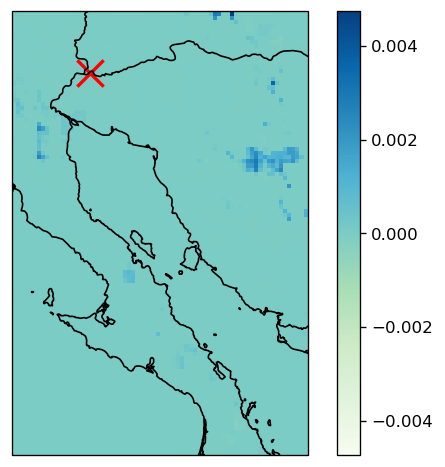

In [11]:
da = pcrglob.get_value_as_xarray("groundwater_recharge")

fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection=crs.PlateCarree())
da.plot(ax=ax, cmap="GnBu")

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS, color="k")
ax.coastlines()

# Add a red cross marker at the location of the Leven River at Newby Bridge
ax.scatter(station_longitude, station_latitude, s=250, c="r", marker="x", lw=2)

<Axes: xlabel='time'>

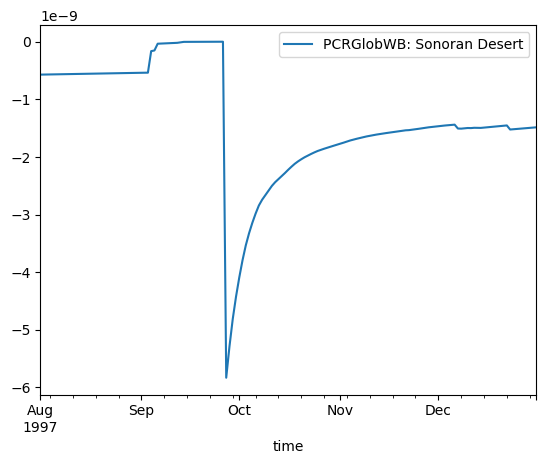

In [12]:
timeseries.plot()

In [ ]:
pcrglob.finalize()